In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phiusiil-phishing-url/PhiUSIIL_Phishing_URL_Dataset.csv
/kaggle/input/finetunedbertmodel/pytorch/default/1/config.json
/kaggle/input/finetunedbertmodel/pytorch/default/1/training_args.bin
/kaggle/input/finetunedbertmodel/pytorch/default/1/tokenizer.json
/kaggle/input/finetunedbertmodel/pytorch/default/1/tokenizer_config.json
/kaggle/input/finetunedbertmodel/pytorch/default/1/model.safetensors
/kaggle/input/finetunedbertmodel/pytorch/default/1/special_tokens_map.json
/kaggle/input/finetunedbertmodel/pytorch/default/1/vocab.txt


In [2]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    cuda_version = torch.version.cuda
    print(f"CUDA Version: {cuda_version}")
else:
    print("CUDA is not available on this system.")

CUDA Version: 12.1


In [3]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import torch
import transformers as tf
import warnings
import os
import multiprocessing


warnings.filterwarnings('ignore')

In [4]:
df_raw = pd.read_csv('/kaggle/input/phiusiil-phishing-url/PhiUSIIL_Phishing_URL_Dataset.csv')

In [5]:
df_raw.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [6]:
columns = [ 'URL'  ,'Domain', 'TLD',  'URLSimilarityIndex' ,'NoOfOtherSpecialCharsInURL' , 
 'SpacialCharRatioInURL','IsHTTPS', 'LineOfCode' ,'Title' , 'DomainTitleMatchScore', 'URLTitleMatchScore' ,'IsResponsive'               
,'HasDescription' , 'HasSocialNet' , 'HasSubmitButton','HasCopyrightInfo' , 'NoOfImage' ,  'NoOfJS', 'NoOfSelfRef'                
   ,'label']
df = df_raw[columns]

In [7]:
cuttoff = int(len(df)*0.5)
df1 = df.iloc[:cuttoff]
df2 = df.iloc[cuttoff:]
df2.head()

,URL,Domain,TLD,URLSimilarityIndex,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,Title,DomainTitleMatchScore,URLTitleMatchScore,IsResponsive,HasDescription,HasSocialNet,HasSubmitButton,HasCopyrightInfo,NoOfImage,NoOfJS,NoOfSelfRef,label
117897,https://www.ife.org.uk,www.ife.org.uk,uk,100.000000,2,0.095,1,2180,ifeorg,0.0,0.0,1,1,1,0,0,16,3,22,1
117898,https://www.rogerfoxwell.co.uk,www.rogerfoxwell.co.uk,uk,100.000000,2,0.069,1,2912,rogerfoxwellco,0.0,0.0,1,1,1,1,1,12,41,116,1
117899,https://www.amblesideonline.org,www.amblesideonline.org,org,100.000000,1,0.033,1,323,amblesideonline,100.0,100.0,1,1,1,1,1,15,0,1,1
117900,http://serv-term-103049.square.site/,serv-term-103049.square.site,site,66.845531,5,0.139,0,13,serv-term-103049square,0.0,0.0,0,0,0,0,0,0,0,1,0
117901,https://3vlocksmith.com/blesmps/login.html,3vlocksmith.com,com,30.350964,4,0.098,1,170,3vlocksmithblesmpsloginhtm,0.0,0.0,0,0,0,0,0,3,2,0,0


In [8]:
sample_data = df2[:5000]
sample_data.reset_index(drop=True, inplace=True)
sub_df2 = sample_data.select_dtypes('object')
print(sub_df2.shape)
sub_df2['label'] = df2['label']
sub_df2['combined'] = sub_df2['URL'] + ' ' + sub_df2['Domain'] + ' ' + sub_df2['TLD'] + ' ' + sub_df2['Title']
sub_df2.head()

(5000, 4)


,URL,Domain,TLD,Title,label,combined
0,https://www.ife.org.uk,www.ife.org.uk,uk,ifeorg,NaN,https://www.ife.org.uk www.ife.org.uk uk ifeorg
1,https://www.rogerfoxwell.co.uk,www.rogerfoxwell.co.uk,uk,rogerfoxwellco,NaN,https://www.rogerfoxwell.co.uk www.rogerfoxwel...
2,https://www.amblesideonline.org,www.amblesideonline.org,org,amblesideonline,NaN,https://www.amblesideonline.org www.amblesideo...
3,http://serv-term-103049.square.site/,serv-term-103049.square.site,site,serv-term-103049square,NaN,http://serv-term-103049.square.site/ serv-term...
4,https://3vlocksmith.com/blesmps/login.html,3vlocksmith.com,com,3vlocksmithblesmpsloginhtm,NaN,https://3vlocksmith.com/blesmps/login.html 3vl...


In [9]:
from transformers import AutoModel, AutoTokenizer

# Specify the path where all your model files are saved
model_dir = "/kaggle/input/finetunedbertmodel/pytorch/default/1/"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dir, model_max_length=512)
# Load the model
model = AutoModel.from_pretrained(model_dir)

In [10]:
tokenized = sub_df2['combined'].apply(lambda x: tokenizer.encode(x, 
                                                                add_special_tokens=True, 
                                                                max_length=512, 
                                                                truncation=True, 
                                                                padding="max_length"))

In [11]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [12]:
np.array(padded).shape

(5000, 512)

In [13]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(5000, 512)

In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model = model.to(device)

# Convert inputs to tensors
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

# Create a TensorDataset and DataLoader for batching
batch_size = 16  # Adjust batch size as per your GPU memory capacity
dataset = TensorDataset(input_ids, attention_mask)
dataloader = DataLoader(dataset, batch_size=batch_size)

# Perform batched inference with GPU support
all_hidden_states = []

with torch.no_grad():
    for batch in dataloader:
        batch_input_ids, batch_attention_mask = [x.to(device) for x in batch]
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        all_hidden_states.append(outputs.last_hidden_state)

# Concatenate all hidden states into a single tensor
last_hidden_states = torch.cat(all_hidden_states, dim=0)

In [15]:
from sklearn.preprocessing import StandardScaler

features = last_hidden_states[:, 0, :].cpu().numpy() 
num_df = sample_data.drop(['URL',	'Domain',	'TLD',	'Title', 'label'], axis=1).values
assert features.shape[0] == sample_data.shape[0]

# Ensure the number of samples match
if features.shape[0] != num_df.shape[0]:
    raise ValueError("Mismatch in the number of samples between features and num_df")

# Concatenate along the feature axis (columns)
combined_features = np.concatenate([features, num_df], axis=1)

print("Combined features shape:", combined_features.shape)

Combined features shape: (5000, 783)


In [16]:
labels = sample_data['label']
labels

0       1
1       1
2       1
3       0
4       0
       ..
4995    1
4996    1
4997    1
4998    0
4999    0
Name: label, Length: 5000, dtype: int64

In [17]:

train_features, test_features, train_labels, test_labels = train_test_split(combined_features, labels, test_size=0.2, stratify=labels)


In [18]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale train_features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

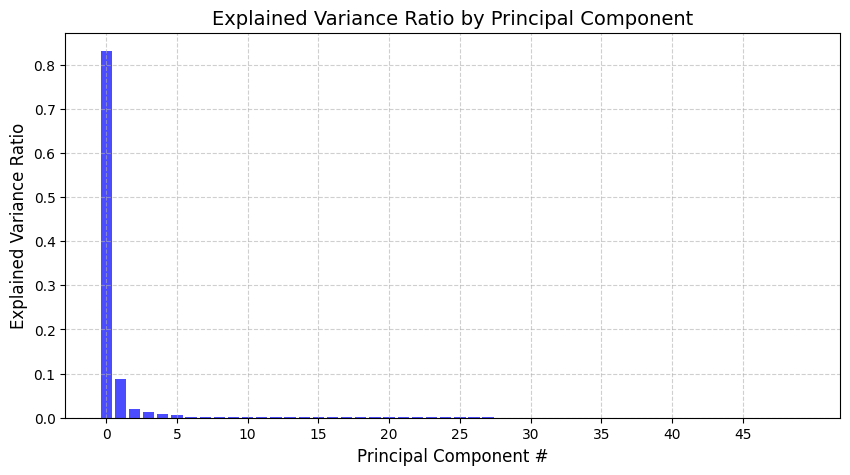

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# Limit to first 50 components for better visibility
num_components_to_plot = min(50, len(exp_variance))

# Plot the explained variance
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust figure size
ax.bar(range(num_components_to_plot), exp_variance[:num_components_to_plot], color='b', alpha=0.7)

# Labels and title
ax.set_xlabel('Principal Component #', fontsize=12)
ax.set_ylabel('Explained Variance Ratio', fontsize=12)
ax.set_title('Explained Variance Ratio by Principal Component', fontsize=14)

# Add grid for readability
ax.grid(True, linestyle='--', alpha=0.6)

# Show only up to the first 50 components
plt.xticks(np.arange(0, num_components_to_plot, step=5))
plt.show()


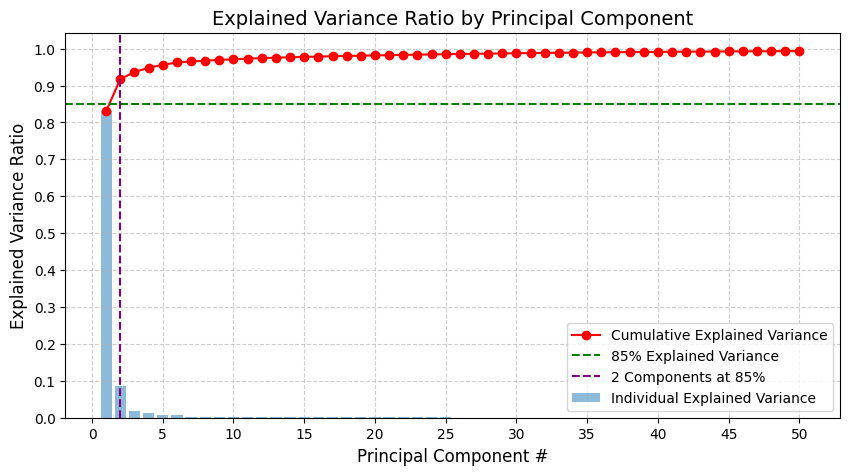

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Determine number of components to reach 85% variance
num_components_85 = np.argmax(cum_exp_variance >= 0.85) + 1  # Add 1 for 1-based index

# Limit number of components for better visualization
num_components_to_plot = min(50, len(exp_variance))  # Plot up to 50 or total available

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot individual explained variance as bars
ax.bar(range(1, num_components_to_plot + 1), exp_variance[:num_components_to_plot], 
       alpha=0.5, align='center', label='Individual Explained Variance')

# Plot cumulative explained variance as a red line with markers
ax.plot(range(1, num_components_to_plot + 1), cum_exp_variance[:num_components_to_plot], 
        marker='o', linestyle='-', color='r', label='Cumulative Explained Variance')

# Add dashed horizontal line at 85% variance
ax.axhline(y=0.85, color='g', linestyle='--', label='85% Explained Variance')

# Add vertical line at the number of components reaching 85% variance
ax.axvline(x=num_components_85, color='purple', linestyle='--', label=f'{num_components_85} Components at 85%')

# Labels and title
ax.set_xlabel('Principal Component #', fontsize=12)
ax.set_ylabel('Explained Variance Ratio', fontsize=12)
ax.set_title('Explained Variance Ratio by Principal Component', fontsize=14)

# Customize ticks for better readability
ax.set_xticks(range(0, num_components_to_plot + 1, 5))
ax.set_yticks(np.arange(0, 1.1, 0.1))

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show legend
ax.legend()

# Show plot
plt.show()

In [21]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components=4)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test_features)

In [22]:
# Convert numpy arrays to PyTorch tensors
train_features_tensor = torch.FloatTensor(train_pca)
test_features_tensor = torch.FloatTensor(test_pca)
train_labels_tensor = torch.LongTensor(train_labels.values)
test_labels_tensor = torch.LongTensor(test_labels.values)

# Create datasets
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

# DataLoader for batch processing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN architecture
class BinaryClassifierCNN(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifierCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (input_size // 4), 20)  # Adjust based on input size
        self.fc2 = nn.Linear(20, 64)
        self.fc3 = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Reshape input for Conv1d: (batch_size, 1, seq_length)
        x = x.view(x.size(0), 1, -1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return torch.sigmoid(x)

# Initialize the model, loss function, and optimizer
input_size = train_features_tensor.shape[1]  # Total features after concatenation
model = BinaryClassifierCNN(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Training loop
train_losses = []
val_losses = []

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Average training loss for this epoch
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()
    
    # Average validation loss for this epoch
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1, Training Loss: 0.1172, Validation Loss: 0.0182
Epoch 2, Training Loss: 0.1031, Validation Loss: 0.0225
Epoch 3, Training Loss: 0.0252, Validation Loss: 0.1953
Epoch 4, Training Loss: 0.0721, Validation Loss: 0.0280
Epoch 5, Training Loss: 0.0640, Validation Loss: 0.1953


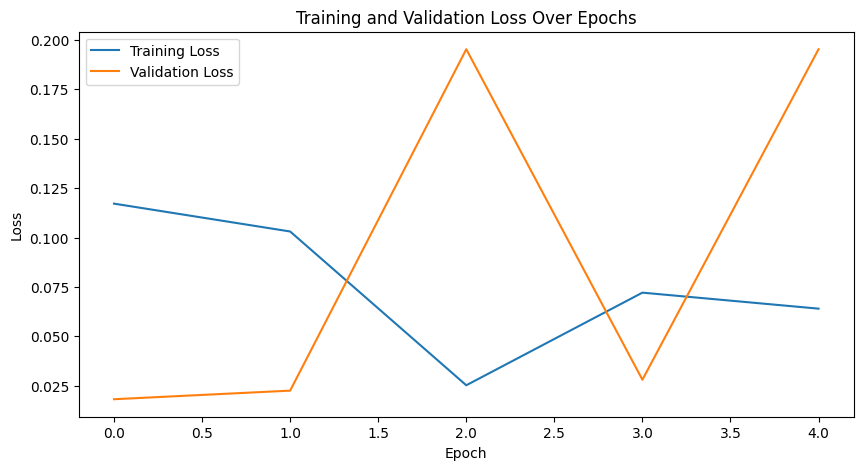

In [24]:
import matplotlib.pyplot as plt


# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Final evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        all_preds.extend(predicted.squeeze().tolist())
        all_labels.extend(labels.tolist())
        total += labels.size(0)
        correct += (predicted.squeeze() == labels.float()).sum().item()

    print(f'Final Test Accuracy: {100 * correct / total:.2f}%')

Final Test Accuracy: 99.80%



Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       441
     Class 1       1.00      1.00      1.00       559

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Confusion Matrix:
[[439   2]
 [  0 559]]


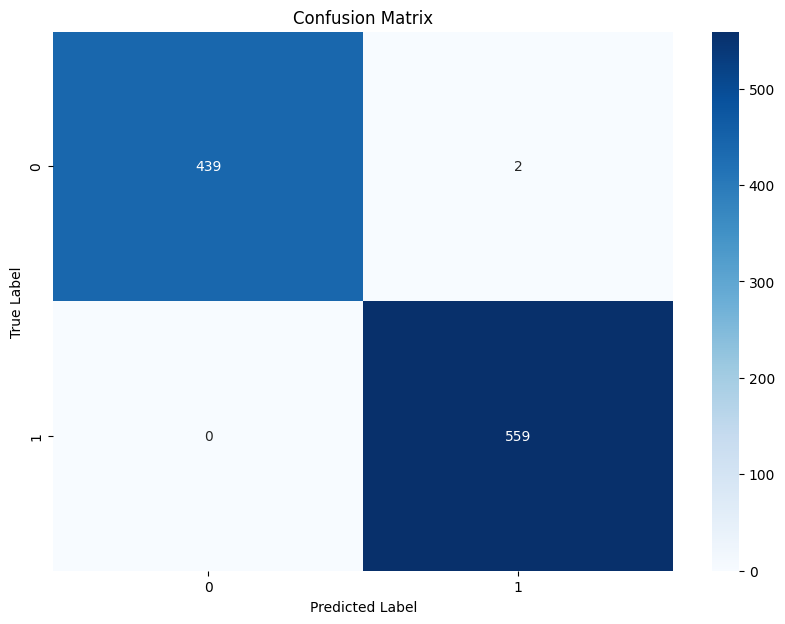

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming you've already run the training loop and have these lists:
# all_preds - list of predictions
# all_labels - list of true labels

# Convert lists to numpy arrays for easier manipulation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds.round(), target_names=['Class 0', 'Class 1']))

# Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(all_labels, all_preds.round())
print(conf_matrix)

# Optionally, you can visualize the confusion matrix with matplotlib if available
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()